# Reading cbmsim simulation TTree with uproot

uproot https://pypi.org/project/uproot/ is a python package to provide I/O libraries for ROOT files, without the need for ROOT itself to be installed.ù

Branches are converted into awkarwd arrays, which allow easy access and handling (https://awkward-array.readthedocs.io)

Nota Bene: old simulation hits are not readable automatically (i.e. before FairROOT end of 2020 update). However, they can still be read by uproot by providing the interpretation manually

## Introduction
First, we need to install uproot, if it was not already done

In [1]:
pip install --user uproot

Note: you may need to restart the kernel to use updated packages.


In [2]:
import uproot
import awkward #need for flatten or other operations to nested arrays
import numpy as np
import matplotlib.pyplot as plt #for plots

## Opening file, retrieving TTree
I will make an example of a muon neutrino simulation, but any cbmsim simulation from SND@LHC should work

In [3]:
simfile = uproot.open("/eos/user/a/aiulian/sim_snd/nutau_SND_18_June_2021/1/ship.conical.Genie-TGeant4.root")
simtree = simfile["cbmsim"] 

Let us write the functions to access MCTrack and FairMCPoint branches

In [4]:
def access_track_branches(simtree, prefix="MCTrack.f", entry_start=0, entry_stop = -1):
 '''reading MCTracks from entry_start to lastentry'''
 if (entry_stop < 0):
        lastentry = simtree.num_entries
 else:
        lastentry = entry_stop
 #what branches do we want to read
 suffixes = ["MotherId","PdgCode","StartX","StartY","StartZ","Px","Py","Pz"]
 branchnames = [prefix + suff for suff in suffixes]
 print(branchnames)
 #reading the branches
 tracks = simtree.arrays(branchnames,entry_start = entry_start, entry_stop = lastentry)
 #returning the produced array
 return tracks

In [5]:
def access_mcpoint_branches(simtree, prefix = "ScifiPoint.f", entry_start=0, entry_stop = -1 ):
 '''reading MCTracks from entry_start to lastentry'''
 if (entry_stop < 0):
        lastentry = simtree.num_entries
 else:
        lastentry = entry_stop   

 suffixes = ["PdgCode","TrackID","X","Y","Z","Px","Py","Pz"]
 branchnames = [prefix + suff for suff in suffixes]
 print(branchnames)
 #reading the branches
 mcpoints = simtree.arrays(branchnames[0:2],entry_start = entry_start, entry_stop = lastentry)
 #adding float interpretation manually
 floatinterpretation = simtree["MCTrack.fStartX"].interpretation
 for name in branchnames[2:]:
  mcpoints[name] = simtree[name].array(floatinterpretation)
 #returning the produced array
 return mcpoints

In [6]:
tracks = access_track_branches(simtree)

['MCTrack.fPdgCode', 'MCTrack.fStartX', 'MCTrack.fStartY', 'MCTrack.fStartZ', 'MCTrack.fPx', 'MCTrack.fPy', 'MCTrack.fPz']


In [7]:
scifihits = access_mcpoint_branches(simtree)

['ScifiPoint.fPdgCode', 'ScifiPoint.fTrackID', 'ScifiPoint.fX', 'ScifiPoint.fY', 'ScifiPoint.fZ', 'ScifiPoint.fPx', 'ScifiPoint.fPy', 'ScifiPoint.fPz']


In [8]:
scifihits["ScifiPoint.fX"][10]

<Array [-18.6, -18.2, -15, -15, -15] type='5 * float64'>

In [9]:
nevents = simtree.num_entries #also equal to len(tracks) and len(scifihits)
events = np.arange(0,nevents)

## Computing additional variables
From these arrays, we can easily combine the branches in new ones. For example, we can compute the tri-momentum

In [10]:
tracks['MCTrack.fP'] = np.sqrt(tracks['MCTrack.fPx'] * tracks['MCTrack.fPx'] + tracks['MCTrack.fPy'] * tracks['MCTrack.fPy'] + tracks['MCTrack.fPz'] * tracks['MCTrack.fPz'])

## Check neutrino vertex position
First, we need to check that the neutrino interaction happened within the target position. We write a function for this check

In [11]:
def withintarget(startx, starty):
    targetxmin = -47.6
    targetxmax = -8.0
    targetymin = 15.5
    targetymax = 55.1
    #checking if starting positions are within target
    x_indexes =  np.logical_and(startx < targetxmax , startx > targetxmin)
    y_indexes =  np.logical_and(starty < targetymax , starty > targetymin)
    #returning output
    return np.logical_and(x_indexes, y_indexes)

In [12]:
intargetevents = withintarget(tracks["MCTrack.fStartX"][:,0], tracks["MCTrack.fStartY"][:,0]) #remember, first track is always the neutrino

In [13]:
#how to apply the selection
seltracks = tracks[intargetevents]
selhits = scifihits[intargetevents] 
selevents = events[intargetevents] #to known the number of selected events

Let us plot for example the momentum of neutrinos within our target

(array([274., 225., 190., 106.,  37.,  10.,   3.,   1.,   1.,   2.]),
 array([  46.92541326,  431.39945746,  815.87350166, 1200.34754586,
        1584.82159006, 1969.29563426, 2353.76967846, 2738.24372267,
        3122.71776687, 3507.19181107, 3891.66585527]),
 <BarContainer object of 10 artists>)

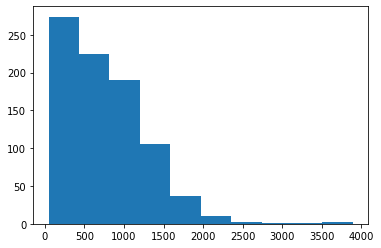

In [14]:
plt.hist(seltracks["MCTrack.fP"][:,0])